## Calculate the IDDs for courses
Here we are going to reproduce the calculations that INEP has done to transform the ENADE scores of individual last-year studentes into a value-added measure, the so-called "IDD" of the course (indicator for deviation from the expected value). 

Briefly, the IDD is calculated as follows. First, a model is estimated for the ENADE score as a function of the ENEM score of the student when they entered:

$$ \text{ENADE}_{ic} = \beta_{0c} + \beta \text{ENEM}_i + \epsilon_i $$
$$\beta_{0c} = N(\beta_{00},\sigma^{2}_{\beta}) $$

As you can see, this is a multi-level model with varying intercepts for courses. The IDD for one course is the sum of the residuals for each N students: $\text{IDD}_{c} = \sum_i \epsilon_i / N$. 

In [258]:
import pandas as pd

def getdata(ano):
    df = pd.read_csv("data/processed/idd-microdata-{}.csv".format(ano))
    df = df.dropna()
    df['anosgrad'] = df['ano'] - df['ingresso']
    df['enem'] = (df['mt'] + df['lc'] + df['ch'] + df['cn'])/4 # note that any missing enem subgrade will give a missing 'enem'
    return df
    
data17 = getdata(2017)
data14 = getdata(2014)
data14[-5:]

,ano,area,ies,catacad,orgacad,curso,municipio,ingresso,nota,cn,ch,lc,mt,anosgrad,enem
155966,2014,6405,15059,10002,10028,113561,1506807,2010,62.7,570.5,655.0,613.6,558.1,4,599.300
155967,2014,6405,15059,10002,10028,113561,1506807,2010,32.2,452.3,537.7,516.5,473.0,4,494.875
155968,2014,6405,15059,10002,10028,113561,1506807,2009,47.3,403.5,354.5,633.0,490.1,5,470.275
155969,2014,6405,15059,10002,10028,113561,1506807,2010,27.6,571.2,649.7,673.9,527.8,4,605.650
155970,2014,6405,15059,10002,10028,113561,1506807,2010,47.9,618.2,576.5,671.8,583.7,4,612.550


In [259]:
# Let's characterize the data, to get an idea what we're dealing with
def summarize(data):
    ano = data['ano'][0]
    N = len(data)
    Ncursos = len(data.curso.unique())
    print("{}: {} students in {} unique courses".format(ano,N,Ncursos))
    print("ENADE:\n",data.nota.mean())
    print("ENEM:\n",data.enem.mean())
    print("\n")
summarize(data17)
summarize(data14)

c17 = set(data17.curso.unique())
c14 = set(data14.curso.unique())

print("Total unique courses:   ",len(c17 | c14))
print("Courses both in 2017 and 2014: ",len(c17 & c14))
print("Courses in 2017 but not in 2014: ",len(c17-c14))
print("Courses in 2014 but not in 2017: ",len(c14-c17))

data14.groupby('curso').size().sort_values()[:5]

2017: 284602 students in 9756 unique courses
ENADE:
 44.99773473130898
ENEM:
 551.6534665076142


2014: 143161 students in 7781 unique courses
ENADE:
 45.87971025628487
ENEM:
 539.7793929561822


Total unique courses:    11042
Courses both in 2017 and 2014:  6495
Courses in 2017 but not in 2014:  3261
Courses in 2014 but not in 2017:  1286


curso
32999     1
25821     1
150319    1
25822     1
417130    1
dtype: int64

In [261]:
data14.groupby('curso')['ano'].size()

curso
3           33
6           47
10          20
16          28
19          31
23          27
24          22
25          25
26           5
29          34
32          16
34           7
36           8
44          32
142         10
150         37
159         15
161          8
163          9
297          7
300         15
310          9
311         20
315          5
317         10
318          8
322          8
326          6
327          6
328         15
          ... 
5000448      7
5000456      6
5000457      5
5000487     10
5000491     16
5000492     10
5000493      8
5000500      1
5000539     13
5000546      6
5000547      5
5000555      4
5000562     13
5000568      7
5000573      3
5000575     15
5000576     25
5000578     39
5000581     48
5000696     11
5000757      7
5000802     25
5000884     60
5000934     26
5001097    143
5001098     53
5001099     59
5001100     30
5001161      7
5001162     12
Name: ano, Length: 7781, dtype: int64

In [271]:
import numpy as np
from pymer4.models import Lmer
import scipy.stats as stats

def multilevel(data,residcomoutlier = True,Nmin=1):
    '''Retorna modelo1 (estimado com outliers) e modelo2 (estimado sem outliers).
    Retorna também os dados originais (com outliers!) e os residuos (calculado 
    pela diferença entre a nota original com a nota prevista pelo modelo2)
    
    Sim, isso não faz sentido.
    '''
    removeroutliers = True
    
    data = data.dropna() # necessário para dados de 2014
    data['ncurso'] = data.groupby('curso')['ano'].transform(lambda x: len(x))
    #data['ncurso'] = data.groupby('curso').size()
    data = data[data['ncurso'] > Nmin] # don't use courses with less than Nmin participants
    formula = 'nota ~ ch + cn + mt + lc + (1|curso)'
    model1 = Lmer(formula,data=data)
    _ = model1.fit(summarize=False);
    if removeroutliers:
        newdata = model1.data.copy()
        newdata['z'] = stats.zscore(newdata.residuals)
        newdata = newdata[abs(newdata.z) < 3]
        model2 = Lmer(formula,data=newdata)
        _ = model2.fit(summarize=False);
    else:
        model2 = model1
    # Descobri que para reproduzir melhor os número do INEP, é preciso
    # *incluir* as notas dos outliers no cálculo do IDD (!)
    # Ou seja, vamos calcular a nota prevista pelo modelo2 (estimado sem outliers)
    # usando os todos os dados, incluindo outliers
    if residcomoutlier:
        model1.data['pred'] = model2.predict(model1.data,use_rfx=True)
        model1.data['resid'] = model1.data.nota - model1.data.pred
        return model1.data
    else:
        return model2.data.rename(columns={'residuals':'resid'})
    
def idd_multilevel(data,area,Nmin=0):
    data = multilevel(data);
    idd = data.groupby('curso').agg({'resid':['sum','mean','size','std'],'enem':'mean','ies':'first','municipio':'first'})
    idd.columns = ['idd_sum','idd','N','std','enem.mean','ies','municipio']
    idd = idd[idd['N'] >= Nmin]
    idd['stderr'] = idd['std']/np.sqrt(idd['N'])
    idd.sort_values('idd',ascending=False,inplace=True)
    idd.insert(0,'rank',range(1,len(idd)+1))
    idd['area'] = area
    return idd


In [274]:
areas17 = set(data17.area)
areas14 = set(data14.area)
areas = areas14 & areas17
idd_calc_ml17 = pd.concat([idd_multilevel(data17.query('area == @area'),area) for area in areas])
idd_calc_ml14 = pd.concat([idd_multilevel(data14.query('area == @area'),area) for area in areas])

In [253]:
#szes = data14.groupby('curso').size()
#szes.sort_values()

In [182]:
idd_inep17 = pd.read_csv('data/processed/idd-pub-2017.csv')
idd_inep17.dropna(inplace=True)
idd_inep17[:3]

,area,curso,N,idd,ano
0,21,44,40.0,0.603662,2017
1,21,132,97.0,0.273903,2017
2,21,1138293,84.0,-0.697898,2017


In [190]:
iddcomp = pd.merge(idd_inep17,idd_calc_ml17,left_on='curso',right_index=True)
iddcomp = iddcomp.rename(columns={'area_x':'area','idd_x':'idd_inep','idd_y':'idd_calc','N_x':'Ninep','N_y':'Ncalc'})
#iddcomp.query("curso == 10149")

,area,curso,Ninep,idd_inep,ano,rank,idd_sum,idd_calc,Ncalc,std,enem.mean,stderr,area_y
140,21,10149,49.0,-0.063328,2017,144,-3.086955,-0.062999,49,10.404074,544.344388,1.486296,21


In [217]:
iddcomp[['idd_calc','idd_inep']].corr()

,idd_calc,idd_inep
idd_calc,1.000000,0.999125
idd_inep,0.999125,1.000000


In [199]:
corrs = iddcomp.groupby('area')[['idd_calc','idd_inep']].corr().iloc[0::2,-1]
corrs = corrs.unstack()
corrs.sort_values('idd_calc')[:5]

,idd_calc
area,
72,0.997079
3201,0.997334
702,0.997492
4004,0.997929
1502,0.997955


In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

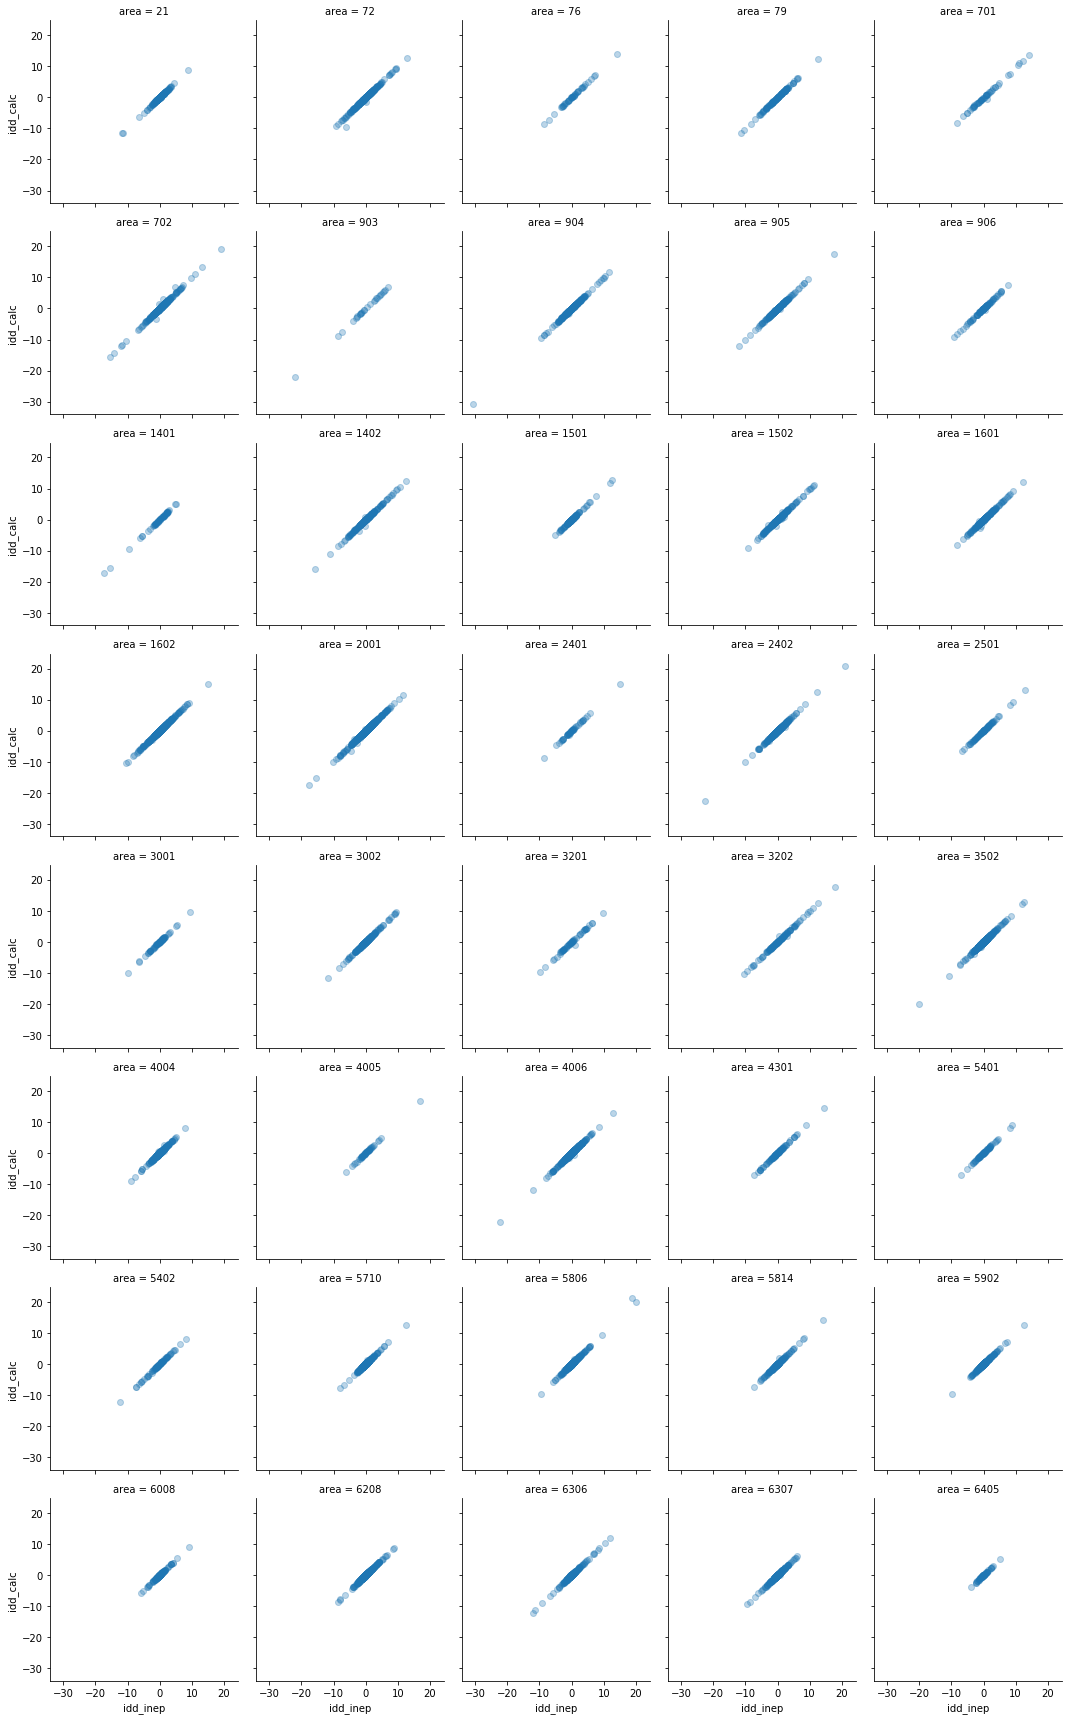

In [192]:
g = sns.FacetGrid(iddcomp,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'idd_inep','idd_calc',alpha=0.3);

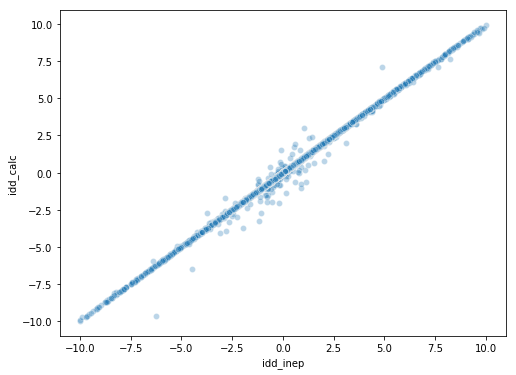

In [201]:
fig = plt.figure(figsize=(8,6))
data = iddcomp[(iddcomp['idd_inep'] < 10) & (idd_comp['idd_inep'] > -10)]
sns.scatterplot(data = data,x='idd_inep',y='idd_calc',alpha=0.3)

In [228]:
iddcomp[['idd_inep','idd_calc']].describe()

,idd_inep,idd_calc
count,9333.000000,9333.000000
mean,0.003842,-0.001835
std,2.499305,2.495928
min,-30.671940,-30.674135
25%,-0.933147,-0.932737
50%,-0.084295,-0.086794
75%,0.858031,0.851030
max,20.863764,21.194490


In [233]:
iddcomp['diff'] = iddcomp['idd_calc'] - iddcomp['idd_inep']
iddcomp[abs(iddcomp['diff']) > 2]

,area,curso,Ninep,idd_inep,ano,rank,idd_sum,idd_calc,Ncalc,std,enem.mean,stderr,area_y,diff
404,72,1166239,3.0,-6.267933,2017,347,-28.897415,-9.632472,3,21.271670,504.291667,12.281204,72,-3.364539
1205,702,96955,9.0,4.891231,2017,6,63.656719,7.072969,9,11.008921,577.100000,3.669640,702,2.181737
1214,702,1161404,10.0,-1.196584,2017,382,-32.553798,-3.255380,10,15.516140,563.032500,4.906634,702,-2.058796
4290,2001,21489,10.0,-4.478088,2017,1105,-65.024795,-6.502480,10,12.966920,492.840000,4.100500,2001,-2.024392
8422,5806,50622,4.0,18.703827,2017,1,84.777961,21.194490,4,9.359645,652.656250,4.679823,5806,2.490664


In [235]:
model = multilevel(data17.query('area == 72'))

In [236]:
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,residuals,fits,pred,resid
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,7.254515,35.745485,39.264467,3.735533
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,4.588906,32.911094,35.971131,1.528869
259475,2017,72,519,5,10028,1166239,2015,0.0,477.0,461.9,479.5,512.8,2,482.800,3,-30.929815,30.929815,34.161817,-34.161817


In [237]:
model = multilevel(data17.query('area == 72'),residcomoutlier=False)
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,resid,fits,z
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,3.735533,39.264467,0.711127
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,1.528869,35.971131,0.449829


In [241]:
model = multilevel(data17.query('area == 72'),Nmin = 1)
model.query('curso == 1166239')

,ano,area,ies,catacad,orgacad,curso,ingresso,nota,cn,ch,lc,mt,anosgrad,enem,ncurso,residuals,fits,pred,resid
259473,2017,72,519,5,10028,1166239,2015,43.0,509.1,511.2,561.1,534.2,2,528.900,3,7.254515,35.745485,39.264467,3.735533
259474,2017,72,519,5,10028,1166239,2015,37.5,513.8,572.8,494.3,423.8,2,501.175,3,4.588906,32.911094,35.971131,1.528869
259475,2017,72,519,5,10028,1166239,2015,0.0,477.0,461.9,479.5,512.8,2,482.800,3,-30.929815,30.929815,34.161817,-34.161817


In [267]:
data14[:4]

,ano,area,ies,catacad,orgacad,curso,municipio,ingresso,nota,cn,ch,lc,mt,anosgrad,enem
0,2014,21,1,10002,10028,44,5103403,2010,66.9,695.9,693.4,688.3,764.0,4,710.400
1,2014,21,1,10002,10028,44,5103403,2010,52.7,676.0,703.8,726.9,588.7,4,673.850
2,2014,21,1,10002,10028,44,5103403,2010,58.2,720.5,728.5,670.2,691.0,4,702.550
3,2014,21,1,10002,10028,44,5103403,2010,62.0,653.3,676.6,662.5,543.5,4,633.975


In [286]:
idd_calc_ml14[:3]

,rank,idd_sum,idd,N,std,enem.mean,ies,municipio,stderr,area
curso,,,,,,,,,,
121602,1,29.221293,9.740431,3,14.128189,607.108333,582,4316907,8.156914,3201
349472,2,16.436348,8.218174,2,17.221034,631.650000,571,4106902,12.177110,3201
121366,3,18.530717,6.176906,3,7.202895,590.708333,2564,2504009,4.158594,3201


In [276]:
cpc14 = pd.read_csv('data/processed/cpc-pub-2014.csv')
cpc14[:3]

,area,ies,municipio,Ncursos,N,idd,ano
0,21,1,5103403,1,32,0.138465,2014
1,21,2,5300108,2,13,NaN,2014
2,21,3,2803609,1,6,NaN,2014


In [296]:
iddcomp14 = pd.merge(idd_calc_ml14.reset_index(),cpc14,on=['area','ies','municipio'],validate='m:1')
iddcomp14 = iddcomp14.rename(columns={'idd_x':'idd_calc','idd_y':'idd_inep'})
iddcomp14 = iddcomp14[iddcomp14['Ncursos']  == 1]
iddcomp14[:2]

,curso,rank,idd_sum,idd_calc,N_x,std,enem.mean,ies,municipio,stderr,area,Ncursos,N_y,idd_inep,ano
0,121602,1,29.221293,9.740431,3,14.128189,607.108333,582,4316907,8.156914,3201,1,3,9.883590,2014
2,121366,3,18.530717,6.176906,3,7.202895,590.708333,2564,2504009,4.158594,3201,1,3,6.155835,2014


In [297]:
corrs = iddcomp14.groupby('area')[['idd_calc','idd_inep']].corr().iloc[0::2,-1]
corrs = corrs.unstack()
corrs.sort_values('idd_calc')[:5]

,idd_calc
area,
5402,0.987227
3201,0.987779
5401,0.987902
4004,0.994418
701,0.996121


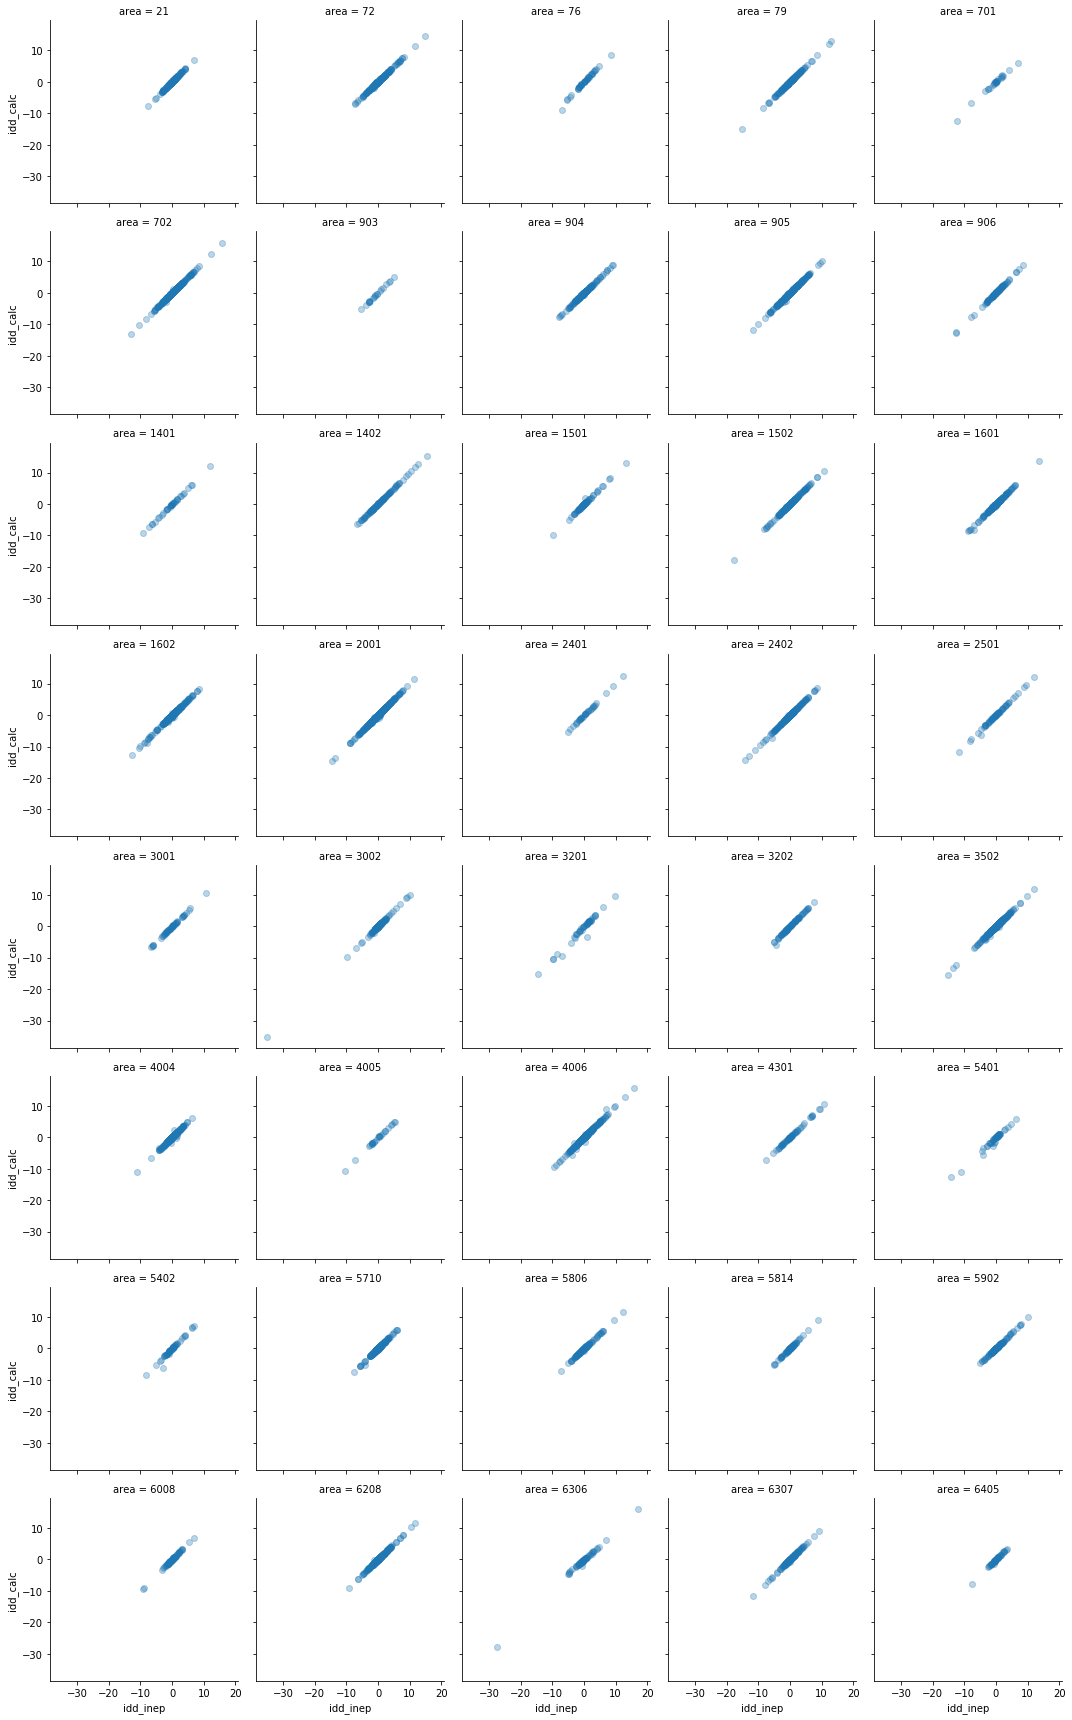

In [298]:
g = sns.FacetGrid(iddcomp14,col='area',height=3,col_wrap=5)
g.map(plt.scatter,'idd_inep','idd_calc',alpha=0.3);

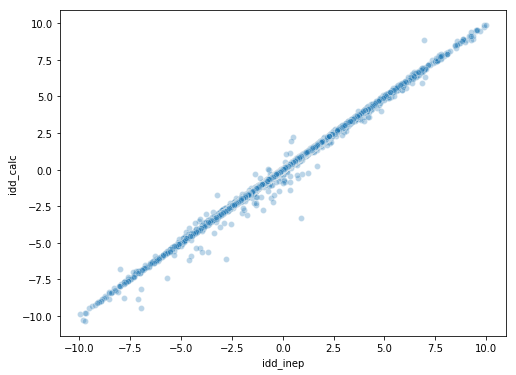

In [301]:
fig = plt.figure(figsize=(8,6))
data = iddcomp14[abs(iddcomp14['idd_inep']) < 10]
sns.scatterplot(data = data,x='idd_inep',y='idd_calc',alpha=0.3)